## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

To not forget anything later, let us globaly define the number of events in the MG sample

In [2]:
lhedatafile = 'data/madminer_lhedata.h5'
detectordatafile = 'data/madminer_detectordata.h5'
nsamples = 10000

## T3 Optimization: ML settings

The setup of the MLForge includes a set of input parameters. So far we have just used the default setup. Now we will see how changing this setup effects the performance of the Machine Learning the the accuracy of the score estimation. 

### T3a) Run the Data Augmentation and Machine Learning part

First, we once again augment the dataand machine learning part again. First at truth level

In [3]:
sa = SampleAugmenter(lhedatafile, debug=False)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='train'
)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='test',
    switch_train_test_events=True
)

and then for detector level

In [4]:
sa_det = SampleAugmenter(detectordatafile, debug=False)

x_det, theta_det, t_xz_det = sa_det.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan_det/',
    filename='train'
)

x_det, theta_det, t_xz_det = sa_det.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan_det/',
    filename='test',
    switch_train_test_events=True
)

### 8b) Define set of settings

In the following, let us define a set of setting. Later we will choose random combinations of these setting options, train the MLForge, evaulate the Fisher Information and compare the results. In particular, we consider the following settings:
- number of epochs
- number of hidden layers of the NN
- number of neurons per hidden layer 
- activation function of the neurons
- initial learning rate
- ratio of initial and final learning rate

In [5]:
choices_epochs = [50,100,200] 
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 

choices_validation = [None]
choices_trainer = ['amsgrad'] 
choices_regularization = [None]  

### T3c) Run the scan

We will store the results of the scan in a separate file. If it already exists, let's just append to it.

In [6]:
usesummaryfile='data/samples_scan/summary.npy'
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

Define the number of scans that is supposed to be performed 

In [7]:
nscan=25

Let us now run the scan. It consists of the following steps

- choose settings randomly 
- create/run MLForge
- evaluate Fisher Info and Mean Squared Error between truth and estimated scores
- save results to summary file 

Note that the run will be the default setting 

In [8]:
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    
    #Setup/train/save ensemble
    forge = MLForge()
    forge_det = MLForge()
    if iscan==0:
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy'
        )   
        forge_det.train(
            method='sally',
            x_filename='./data/samples_scan_det/x_train.npy',
            t_xz0_filename='./data/samples_scan_det/t_xz_train.npy'
        )   
    else: 
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            initial_lr=this_learning[0],
            final_lr=this_learning[1]
        )
        forge_det.train(
            method='sally',
            x_filename='./data/samples_scan_det/x_train.npy',
            t_xz0_filename='./data/samples_scan_det/t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            initial_lr=this_learning[0],
            final_lr=this_learning[1]
        )
    modelsavefile='./models/samples_scan/setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    modelsavefile_det='./models/samples_scan_det/setup_{}/sally_test'.format(iscan)
    forge_det.save(modelsavefile_det)
    
    #Fisher Info 
    fisher = FisherInformation(lhedatafile, debug=False)
    fi_mean_test , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_test.npy'
    )
    fi_mean_train , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_train.npy'
    )
    
    fisher_det = FisherInformation(detectordatafile, debug=False)
    fi_mean_test_det , _ = fisher_det.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile_det,
        unweighted_x_sample_file='./data/samples_scan_det/x_test.npy'
    )
    fi_mean_train_det , _ = fisher_det.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile_det,
        unweighted_x_sample_file='./data/samples_scan_det/x_train.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load('./data/samples_scan/t_xz_test.npy')
    t_ml_test=forge.evaluate('./data/samples_scan/x_test.npy')
    t_pl_train=np.load('./data/samples_scan/t_xz_train.npy')
    t_ml_train=forge.evaluate('./data/samples_scan/x_train.npy')
    t_mse_test = mean_squared_error(t_pl_test,t_ml_test)
    t_mse_train = mean_squared_error(t_pl_train,t_ml_train)
    
    t_pl_test_det=np.load('./data/samples_scan_det/t_xz_test.npy')
    t_ml_test_det=forge_det.evaluate('./data/samples_scan_det/x_test.npy')
    t_pl_train_det=np.load('./data/samples_scan_det/t_xz_train.npy')
    t_ml_train_det=forge_det.evaluate('./data/samples_scan_det/x_train.npy')
    t_mse_test_det = mean_squared_error(t_pl_test_det,t_ml_test_det)
    t_mse_train_det = mean_squared_error(t_pl_train_det,t_ml_train_det)
    
    #Save everything
    newelement= [iscan,
                 index_epochs,index_nhidden,index_nneuron,
                 index_activation,index_lrinitial,index_lrratio,
                 np.linalg.det(fi_mean_test),t_mse_test,
                 np.linalg.det(fi_mean_train),t_mse_train,
                 np.linalg.det(fi_mean_test_det),t_mse_test_det,
                 np.linalg.det(fi_mean_train_det),t_mse_train_det
                ]
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

Do Run Number  0  out of  25


No handlers could be found for logger "madminer.fisherinformation"


Do Run Number  1  out of  25
Do Run Number  2  out of  25
Do Run Number  3  out of  25
Do Run Number  4  out of  25
Do Run Number  5  out of  25
Do Run Number  6  out of  25
Do Run Number  7  out of  25
Do Run Number  8  out of  25
Do Run Number  9  out of  25
Do Run Number  10  out of  25
Do Run Number  11  out of  25
Do Run Number  12  out of  25
Do Run Number  13  out of  25
Do Run Number  14  out of  25
Do Run Number  15  out of  25
Do Run Number  16  out of  25
Do Run Number  17  out of  25
Do Run Number  18  out of  25
Do Run Number  19  out of  25
Do Run Number  20  out of  25
Do Run Number  21  out of  25
Do Run Number  22  out of  25
Do Run Number  23  out of  25
Do Run Number  24  out of  25


### T3c) Plot results

We can now visualize our results as a scatter plot in the Means Squared Error (MSE) vs Fisher Information plane. The dashed line corresponds to the truth level Fisher Information.

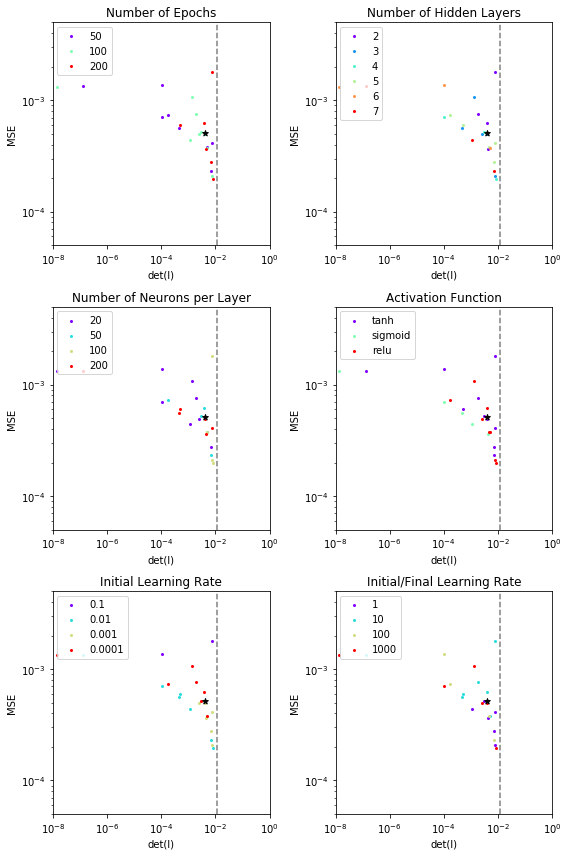

In [9]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)
idx=7 # Det(I) truth test
idy=8 # MSE truth test

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[5*10**(-5),.005]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
f.set_size_inches(8,12)

# choices_nepochs
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_epochs)))
for i in range(len(choices_epochs)):
    thisdata=sublist(data,1,i)
    if len(thisdata)!=0:
        ax1.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_epochs[i]))
ax1.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Number of Epochs')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    if len(thisdata)!=0:
        ax2.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    if len(thisdata)!=0:
        ax3.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    if len(thisdata)!=0:
        ax4.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,5,i)
    if len(thisdata)!=0:
        ax5.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax5.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Initial Learning Rate')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,6,i)
    if len(thisdata)!=0:
        ax6.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax6.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial/Final Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

#######
#Plot
plt.tight_layout()
plt.show()

### T3d) Compare test and train samples

Let us also, as cross check, compare the MSE and Fisher Information of the test amnd train samples

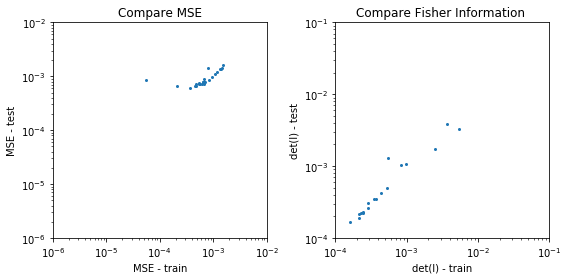

In [10]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000./nsamples)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

add=0 #parton
add=4 #detector

#######
#Figure
myrangefi=[10**(-4),10**(-1)]
myrangemse=[10**(-6),10**(-2)]
mysize=4
f, (ax1,ax2) = plt.subplots(1,2)
f.set_size_inches(8,4)

# MSE
ax1.scatter(data[:,10+add], data[:,8+add],s=mysize,alpha=1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('MSE - train')
ax1.set_ylabel('MSE - test')
ax1.set_xlim(myrangemse)
ax1.set_ylim(myrangemse)
ax1.set_title('Compare MSE')

# Fisher
ax2.scatter(data[:,9+add], data[:,7+add],s=mysize,alpha=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I) - train')
ax2.set_ylabel('det(I) - test')
ax2.set_xlim(myrangefi)
ax2.set_ylim(myrangefi)
ax2.set_title('Compare Fisher Information ')

#######
#Plot
plt.tight_layout()
plt.show()

### T3e) Compare Truth and Detector Samples

Let us also, as cross check, compare the MSE and Fisher Info for the Truth and Detector level samples 

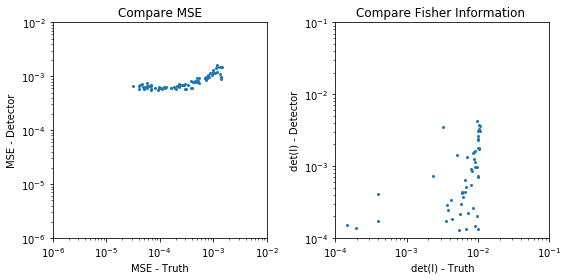

In [32]:
#######
#Input Data
data = np.load(usesummaryfile)

add=2 #train
add=0 #test

#######
#Figure
myrangefi=[10**(-4),10**(-1)]
myrangemse=[10**(-6),10**(-2)]
mysize=4
f, (ax1,ax2) = plt.subplots(1,2)
f.set_size_inches(8,4)

# MSE
ax1.scatter(data[:,8+add], data[:,12+add],s=mysize,alpha=1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('MSE - Truth')
ax1.set_ylabel('MSE - Detector')
ax1.set_xlim(myrangemse)
ax1.set_ylim(myrangemse)
ax1.set_title('Compare MSE')

# Fisher
ax2.scatter(data[:,7+add], data[:,11+add],s=mysize,alpha=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I) - Truth')
ax2.set_ylabel('det(I) - Detector')
ax2.set_xlim(myrangefi)
ax2.set_ylim(myrangefi)
ax2.set_title('Compare Fisher Information ')

#######
#Plot
plt.tight_layout()
plt.show()

### T3f) Get list of good settings

Let us now output the best settings

In [11]:
#Sorted by
idsort=8 # test Parton
idsort=12 # test Detector

#Input Data
data = np.load(usesummaryfile)
data_sort = data[data[:,idsort].argsort()[::1]][:5,:]

for i in range(len(data_sort)):
    print ('Setting with det(I)=',data_sort[i,7],'and MSE=',data_sort[i,8], 'had settings')
    print (' - Number of Epochs:',choices_epochs[int(data_sort[i,1])])
    print (' - Number of Hidden Layers:',choices_nhidden[int(data_sort[i,2])])
    print (' - Number of Neurons per Layer:',choices_nneuron[int(data_sort[i,3])])
    print (' - Activation Function:',choices_activation[int(data_sort[i,4])])
    print (' - Initial Learning Rate:',choices_lrinitial[int(data_sort[i,5])])
    print (' - Final Learning Rate:',choices_lrinitial[int(data_sort[i,6])]/choices_lrratio[int(data_sort[i,5])])
    print ('')

Setting with det(I)= 0.007032454293239243 and MSE= 0.0002318642349305051 had settings
 - Number of Epochs: 50
 - Number of Hidden Layers: 7
 - Number of Neurons per Layer: 50
 - Activation Function: tanh
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.0001

Setting with det(I)= 0.007025577365531154 and MSE= 0.0002763607103279089 had settings
 - Number of Epochs: 200
 - Number of Hidden Layers: 5
 - Number of Neurons per Layer: 20
 - Activation Function: tanh
 - Initial Learning Rate: 0.001
 - Final Learning Rate: 0.001

Setting with det(I)= 0.0011384386870262697 and MSE= 0.00044137745531646846 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 7
 - Number of Neurons per Layer: 20
 - Activation Function: sigmoid
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.01

Setting with det(I)= 0.008207368285977953 and MSE= 0.0001964447755139141 had settings
 - Number of Epochs: 200
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 100
 - Activation Fun